# Clustering: Wrangle Zillow Exercises

## Acquire (acquire.py)
For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

You will have a zillow.ipynb file and a helper file for each section in the pipeline.

## acquire & summarize
### 1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

- Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
- Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.
- Only include properties that include a latitude and longitude value.

In [41]:
import pandas as pd
import numpy as np
import os

import env
import wrangle_zillow

import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [42]:
df = wrangle_zillow.get_zillow_data(cached=False)
df.head(1)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1087254,10711855,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.007357,2017-07-07,None,None,None,Central,Single Family Residential,None,None


## 2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [43]:
df.shape

(77575, 68)

In [44]:
df.columns

Index(['id', 'parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardb

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77575 entries, 0 to 77574
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77575 non-null  int64  
 1   parcelid                      77575 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77575 non-null  float64
 6   bedroomcnt                    77575 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49809 non-null  float64
 9   calculatedbathnbr             76960 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77375 non-null  float64
 13  f

In [46]:
#sort the columns by null values
df.isnull().sum().sort_values(ascending = False)[:45]

buildingclassdesc           77560
buildingclasstypeid         77560
finishedsquarefeet13        77533
basementsqft                77525
storydesc                   77525
storytypeid                 77525
yardbuildingsqft26          77505
fireplaceflag               77403
architecturalstyledesc      77369
architecturalstyletypeid    77369
typeconstructiontypeid      77353
typeconstructiondesc        77353
finishedsquarefeet6         77189
pooltypeid10                77110
decktypeid                  76961
poolsizesum                 76706
pooltypeid2                 76501
hashottuborspa              76036
yardbuildingsqft17          75182
taxdelinquencyflag          74675
taxdelinquencyyear          74675
finishedsquarefeet15        74548
finishedsquarefeet50        71540
finishedfloor1squarefeet    71540
fireplacecnt                69288
threequarterbathnbr         67470
pooltypeid7                 62497
poolcnt                     61402
numberofstories             59979
airconditionin

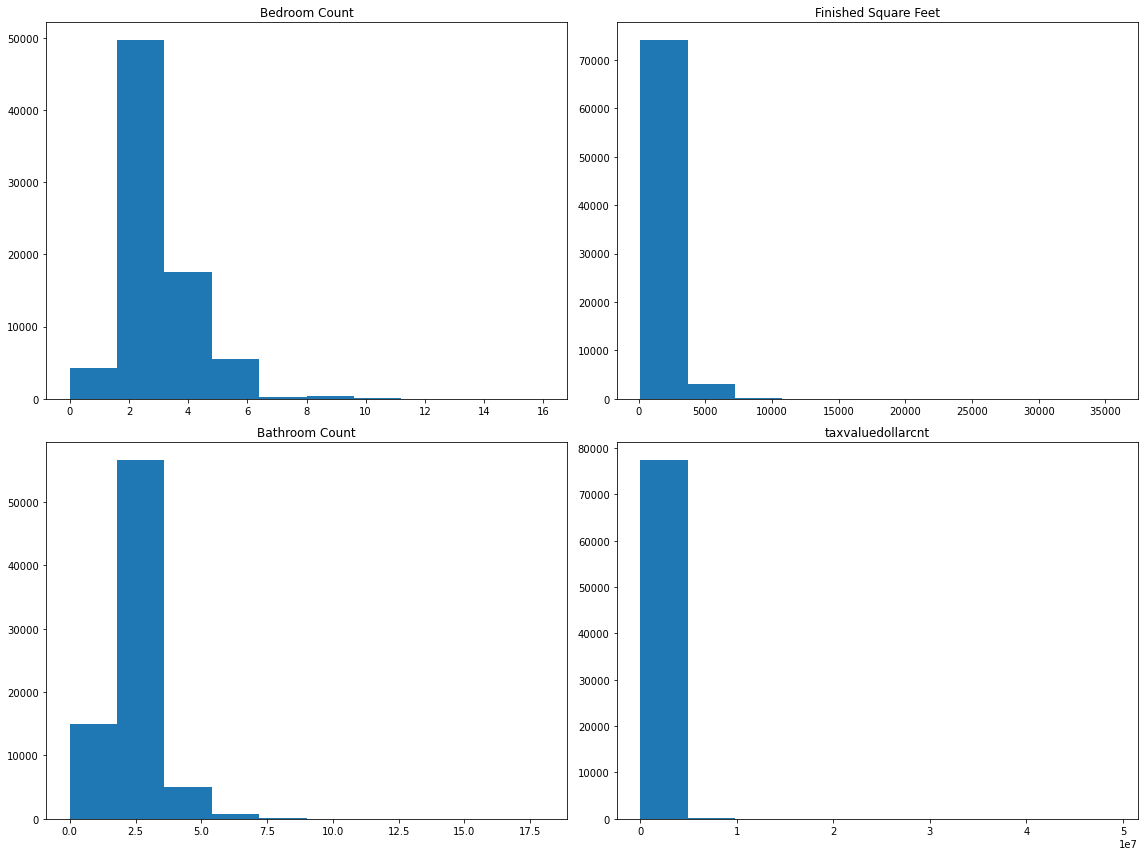

In [47]:
# visualize the distributions for select features

plt.figure(figsize = (16,12))
plt.subplot(221)
plt.hist(df.bedroomcnt)
plt.title('Bedroom Count')



plt.subplot(222)
plt.hist(df.calculatedfinishedsquarefeet)
plt.title('Finished Square Feet')



plt.subplot(223)
plt.hist(df.bathroomcnt)
plt.title('Bathroom Count')



plt.subplot(224)
plt.hist(df.taxvaluedollarcnt)
plt.title('taxvaluedollarcnt')

plt.tight_layout();

## 3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [48]:
def calc_nulls(df):
    null_stats = pd.DataFrame(df.isnull().sum())
    null_stats.rename(columns={0: 'number_of_rows_with_nulls'}, inplace=True)
    null_stats['row_null_percentage'] = df.isnull().sum()/len(df)*100
    return null_stats

In [49]:
null_stats = calc_nulls(df)
null_stats.sort_values(by="row_null_percentage", ascending=False).head()

,number_of_rows_with_nulls,row_null_percentage
buildingclassdesc,77560,99.980664
buildingclasstypeid,77560,99.980664
finishedsquarefeet13,77533,99.945859
storytypeid,77525,99.935546
basementsqft,77525,99.935546


## 3a. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [50]:
#Calculate nulls for each row
pd.DataFrame(df.isnull().sum(axis=1), columns = ['num_cols_missing']).reset_index().groupby('num_cols_missing')\
.count().reset_index().rename(columns={'index': 'num_rows'})

,num_cols_missing,num_rows
0,23,2
1,24,13
2,25,24
3,26,65
4,27,316
5,28,457
6,29,5285
7,30,3465
8,31,9911
9,32,12606


In [51]:
def cols_missing(df):
    df2 = pd.DataFrame(df.isnull().sum(axis =1), columns = ['num_cols_missing']).reset_index()\
    .groupby('num_cols_missing').count().reset_index().\
    rename(columns = {'index': 'num_rows' })
    df2['pct_cols_missing'] = df2.num_cols_missing/df.shape[1] #calculate the % of columns with n # of nulls 
    return df2

In [52]:
# sort valyes by pc_col_missing
cols_missing(df).sort_values(by = ['pct_cols_missing'], ascending = False)

,num_cols_missing,num_rows,pct_cols_missing
25,48,3,0.705882
24,47,3,0.691176
23,46,5,0.676471
22,45,50,0.661765
21,44,79,0.647059
20,43,29,0.632353
19,42,26,0.617647
18,41,29,0.602941
17,40,230,0.588235
16,39,285,0.573529


# Prepare

## 1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [53]:
df.propertylandusetypeid.value_counts()

261.0    52439
266.0    19341
246.0     2021
269.0     1947
248.0      729
247.0      539
265.0      335
263.0       74
275.0       59
260.0       41
267.0       29
31.0        15
264.0        6
Name: propertylandusetypeid, dtype: int64

In [54]:
# Restrict df to only properties that meet single unit criteria

single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
df = df[df.propertylandusetypeid.isin(single_use)]

df.shape

(71860, 68)

## 2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

- The input:
    - A dataframe
    - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
    - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
    
- The output:
    - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.

- hint:
    - Look up the dropna documentation.
    - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
    - Make use of inplace, i.e. inplace=True/False.

In [55]:
def handle_missing_values(df, prop_required_row = 0.5, prop_required_col = 0.5):
    ''' funtcion which takes in a dataframe, required notnull proportions of non-null rows and columns.
    drop the columns and rows columns based on theshold:'''
    
    #drop columns with nulls
    threshold = int(prop_required_col * len(df.index)) # Require that many non-NA values.
    df.dropna(axis = 1, thresh = threshold, inplace = True)
    
    #drop rows with nulls
    threshold = int(prop_required_row * len(df.columns)) # Require that many non-NA values.
    df.dropna(axis = 0, thresh = threshold, inplace = True)
    
    
    return df

In [56]:
df = handle_missing_values(df, prop_required_row = 0.5, prop_required_col = 0.5)

In [57]:
df.shape

(71860, 34)

## 3. Decide how to handle the remaining missing values:

- Fill with constant value.
- Impute with mean, median, mode.
- Drop row/column

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71860 entries, 0 to 77573
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            71860 non-null  int64  
 1   parcelid                      71860 non-null  int64  
 2   bathroomcnt                   71860 non-null  float64
 3   bedroomcnt                    71860 non-null  float64
 4   buildingqualitytypeid         45068 non-null  float64
 5   calculatedbathnbr             71637 non-null  float64
 6   calculatedfinishedsquarefeet  71704 non-null  float64
 7   finishedsquarefeet12          71525 non-null  float64
 8   fips                          71860 non-null  float64
 9   fullbathcnt                   71637 non-null  float64
 10  heatingorsystemtypeid         46684 non-null  float64
 11  latitude                      71860 non-null  float64
 12  longitude                     71860 non-null  float64
 13  l

In [58]:
#sort the columns by null values
df.isnull().sum().sort_values(ascending = False)

buildingqualitytypeid           26792
unitcnt                         26419
propertyzoningdesc              26375
heatingorsystemtypeid           25176
heatingorsystemdesc             25176
lotsizesquarefeet                8130
regionidcity                     1336
finishedsquarefeet12              335
censustractandblock               227
fullbathcnt                       223
calculatedbathnbr                 223
yearbuilt                         191
calculatedfinishedsquarefeet      156
structuretaxvaluedollarcnt         94
regionidzip                        44
taxamount                           5
landtaxvaluedollarcnt               2
taxvaluedollarcnt                   1
fips                                0
bathroomcnt                         0
bedroomcnt                          0
parcelid                            0
propertylandusedesc                 0
latitude                            0
longitude                           0
propertycountylandusecode           0
propertyland

<AxesSubplot:>

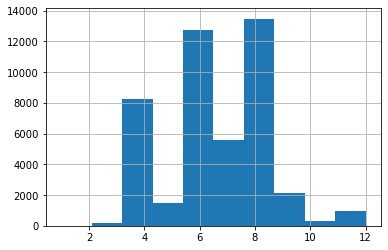

In [59]:
#Dist of building type id
df.buildingqualitytypeid.hist()

<AxesSubplot:>

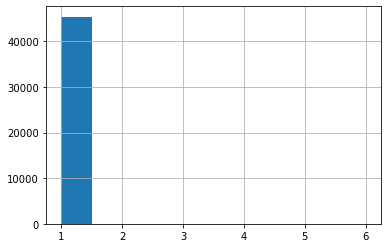

In [60]:
#Dist of unitcnt...should be 1
df.unitcnt.hist()

<AxesSubplot:>

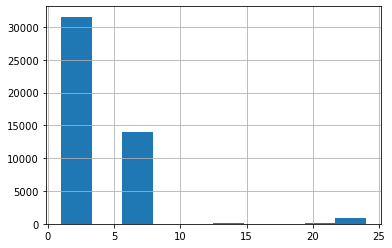

In [61]:
#Dist of heatingsystemtypeid
df.heatingorsystemtypeid.hist()

In [62]:
#Value Counts for heating system desc
df.heatingorsystemdesc.value_counts()

Central       31565
Floor/Wall    13292
Yes             850
Forced air      776
Solar           101
None             60
Radiant          23
Baseboard        13
Gravity           3
Heat Pump         1
Name: heatingorsystemdesc, dtype: int64

<AxesSubplot:>

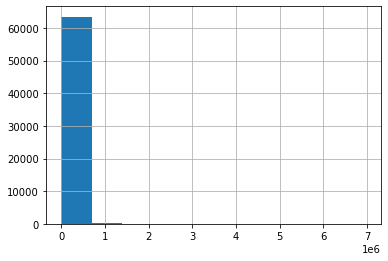

In [63]:
#Dist of lot size squarefeet 
df.lotsizesquarefeet.hist()

<AxesSubplot:>

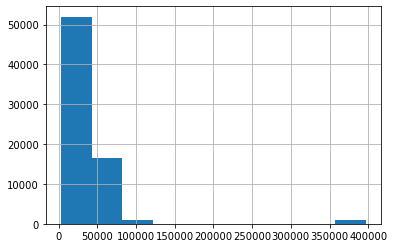

In [64]:
#Region City ID
df.regionidcity.hist()

<AxesSubplot:>

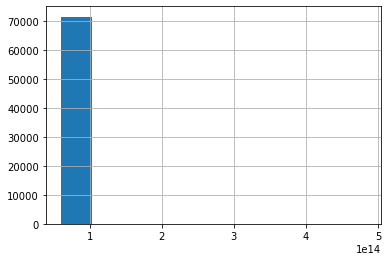

In [65]:
#Visulaize censure tract and block
df.censustractandblock.hist()

In [66]:
#Decisions for nulls

#These columns are duplicated information from other columns:
cols_to_drop = ['fullbathcnt','heatingorsystemtypeid','finishedsquarefeet12', 
                'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc', 'censustractandblock',
                'propertylandusedesc', 'buildingqualitytypeid' , 'unitcnt', 'heatingorsystemdesc', 
                'lotsizesquarefeet','regionidcity', 'calculatedbathnbr']

df.drop(columns=cols_to_drop, inplace = True)

In [67]:
#sort the columns by null values
df.isnull().sum().sort_values(ascending = False)

buildingqualitytypeid           26792
unitcnt                         26419
heatingorsystemdesc             25176
lotsizesquarefeet                8130
regionidcity                     1336
calculatedbathnbr                 223
yearbuilt                         191
calculatedfinishedsquarefeet      156
structuretaxvaluedollarcnt         94
regionidzip                        44
taxamount                           5
landtaxvaluedollarcnt               2
taxvaluedollarcnt                   1
fips                                0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
logerror                            0
assessmentyear                      0
latitude                            0
longitude                           0
rawcensustractandblock              0
transactiondate                     0
regionidcounty                      0
roomcnt                             0
id                                  0
dtype: int64

In [73]:
df.dropna(inplace = True)

In [74]:
df.shape

(71546, 20)

# Mall Customers

## In Notebook:
- Acquire data from mall_customers.customers in mysql database.
- Summarize data (include distributions and descriptive statistics).
- Detect outliers using IQR.
- Split data (train, validate, and test split).
- Encode categorical columns using a one hot encoder (pd.get_dummies).
- Handles missing values.
- Scaling

In [29]:
import wrangle_mall

In [30]:
df = wrangle_mall.get_mall_data(cached=True)
df.head(1)

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.4+ KB


In [32]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### Outliers

<AxesSubplot:ylabel='spending_score'>

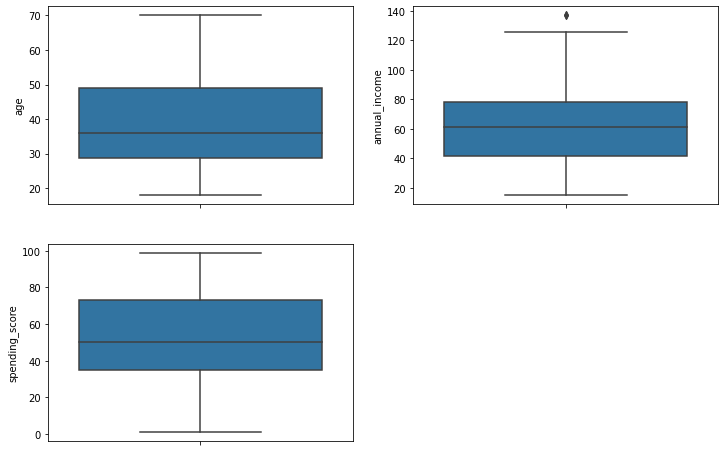

In [33]:
#Visualize outliers
plt.figure(figsize = (12,8))
plt.subplot(221)
sns.boxplot(y = df.age)

plt.subplot(222)
sns.boxplot(y = df.annual_income)

plt.subplot(223)
sns.boxplot(y = df.spending_score)

In [34]:
# function to detect and eliminate outliers using IQR rule

def outlier_function(df, cols, k):
    for col in df[cols]:
        q1 = df.annual_income.quantile(0.25)
        q3 = df.annual_income.quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr     
        df = df[(df[col] < upper_bound) & (df[col] > lower_bound)]
    return df

In [35]:
# use the outlier function defined above to handle outliers in numeric columns. k = 1.5

df = outlier_function(df, ['age', 'spending_score', 'annual_income'], 1.5)
df.shape

(198, 5)

In [36]:
df.set_index('customer_id', inplace=True)

### Encoding

In [37]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # create a mask of columns whether they are object type or not
    mask = np.array(df.dtypes == "object")

        
    # get a list of the column names that are objects (from the mask)
    object_cols = df.iloc[:, mask].columns.tolist()
    
    return object_cols

def create_dummies(df, object_cols):
    '''
    This function takes in a dataframe and list of object column names,
    and creates dummy variables of each of those columns. 
    It then appends the dummy variables to the original dataframe. 
    It returns the original df with the appended dummy variables. 
    '''
    
    # run pd.get_dummies() to create dummy vars for the object columns. 
    # we will drop the column representing the first unique value of each variable
    # we will opt to not create na columns for each variable with missing values 
    # (all missing values have been removed.)
    dummy_df = pd.get_dummies(df[object_cols], dummy_na=False, drop_first=True)
    
    # concatenate the dataframe with dummies to our original dataframe
    # via column (axis=1)
    df = pd.concat([df, dummy_df], axis=1)

    return df

In [38]:
object_cols = get_object_cols(df)
create_dummies(df, object_cols)

,gender,age,annual_income,spending_score,gender_Male
customer_id,,,,,
1,Male,19,15,39,1
2,Male,21,15,81,1
3,Female,20,16,6,0
4,Female,23,16,77,0
5,Female,31,17,40,0
...,...,...,...,...,...
194,Female,38,113,91,0
195,Female,47,120,16,0
196,Female,35,120,79,0


### Scaling

In [39]:
def train_validate_test(train, validate, test, target, bins=5):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [40]:
def min_max_scale(X_train, X_validate, X_test, numeric_cols):
    '''
    this function takes in 3 dataframes with the same columns, 
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).


    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_train[numeric_cols])
    
     #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    X_train_scaled_array = scaler.transform(X_train[numeric_cols])
    X_validate_scaled_array = scaler.transform(X_validate[numeric_cols])
    X_test_scaled_array = scaler.transform(X_test[numeric_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, 
                                  columns=numeric_cols).\
                                  set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled_array, 
                                     columns=numeric_cols).\
                                     set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, 
                                 columns=numeric_cols).\
                                 set_index([X_test.index.values])

    
    return X_train_scaled, X_validate_scaled, X_test_scaled

## In wrangle_mall.py
- Acquire data from mall_customers.customers in mysql database.
- Split the data into train, validate, and split
- One-hot-encoding (pd.get_dummies)
- Missing values
- Scaling